In [1]:
import pandas as pd
import numpy as np
import arviz as az
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import datetime as dt
import sys

from heston_model.stan_runner import StanRunner
from heston_model.utility.helpers import create_data_dict

mpl.rcParams['figure.figsize'] = [6, 4]
mpl.rcParams['font.size'] = 12   
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['errorbar.capsize'] = 4
sns.set_style('whitegrid')
plt.style.use('ggplot')


/home/nsand/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
file_name = 'stan_code/heston_modified.stan'

In [3]:
df = pd.DataFrame()
stock_name = 'TD.TO'

start_date = '2010-01-01'


df = pd.read_parquet(f'data/{stock_name}.parquet')[['close', 'volume']]
df['log_ret'] = np.log(df['close']).diff()

df = df[pd.to_datetime(df.index) > start_date]

df.head()

,close,volume,log_ret
date,,,
2010-01-04,32.82,4252600,-0.004863
2010-01-05,32.51,2400200,-0.009490
2010-01-06,32.19,5571600,-0.009892
2010-01-07,31.91,4280000,-0.008736
2010-01-08,31.87,2465000,-0.001254


In [4]:
data = create_data_dict(
    df.log_ret,
    N_days_future = 252
    )

model = StanRunner(
    code_path = file_name,
    cmdstan_outdir = 'cmdstan'
)

ValueError: no such file /home/nsand/Documents/finance/modified-bayesian-heston-model/notebooks/heston_model/stan_code/heston_modified.stan

In [ ]:
model.sample(
    data,
    num_samples = 1000,
    chains = 4,
    max_treedepth = 11,
)

print(model.get_diagnostics())

21:57:56 - cmdstanpy - INFO - CmdStan start processing


Clearing cmdstan dir...
cmdstan/heston-20250830215609_0-stdout.txt
cmdstan/heston-20250830215609_2-stdout.txt
cmdstan/heston-20250830215609_3-stdout.txt
cmdstan/heston-20250830215609_1.csv
cmdstan/heston-20250830215609_4.csv
cmdstan/heston-20250830215609_1-stdout.txt
cmdstan/heston-20250830215609_3.csv
cmdstan/heston-20250830215609_2.csv
Removed 8 files


chain 1 |          | 00:00 Status



chain 1 |▉         | 00:22 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:26 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:28 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:29 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:30 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:31 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:32 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |████      | 00:33 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:34 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:34 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:35 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:36 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:36 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:37 Iteration: 1300 / 2000 [ 65%]  (Sampli


21:58:38 - cmdstanpy - INFO - CmdStan done processing.
21:58:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'heston.stan', line 67, column 8 to column 49)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'heston.stan', line 67, column 8 to column 49)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'heston.stan', line 67, column 8 to column 49)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'heston.stan', line 67, column 8 to column 49)
	Exception: normal_lpdf: Location parameter is -inf, but must be finite! (in 'heston.stan', line 67, column 8 to column 49)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'heston.stan', line 67, column 8 to column 49)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'heston.stan', line 67, column 8 to column 49)
Exception: normal_lpdf: Location par


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



In [ ]:
# Define coordinates for the Heston model
coords = {
    'T': pd.to_datetime(df.index).tolist(),            # datetime stamps for training set returns
    'T_future': pd.date_range(                         # datetime stamps for future (oos) returns
        start = df.index[-1] + pd.Timedelta(days=1),
        periods = data['T_future'], freq = 'B'
    ).tolist(),
    'T - 1' : pd.to_datetime(df.index[:-1]).tolist(),  # datetime stamps for training set returns except final (some parameters do not have a final value)
}

# Define observed data
observed_data = {
    'returns': df.log_ret.values
}

# Create InferenceData object
model.generate_idata(
    coords = coords,
    observed_data = observed_data
)

idata = model.idata

In [ ]:
# Summary diagnostics
summary_df = model.get_summary()

summary_df.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.001,0.000,-0.000,0.001,0.000,0.000,3715.0,2816.0,1.00
kappa,0.885,0.107,0.690,1.094,0.003,0.001,1440.0,2481.0,1.00
log_theta,-9.311,0.078,-9.461,-9.171,0.002,0.001,1668.0,2018.0,1.00
sigma,0.611,0.060,0.499,0.724,0.001,0.001,1943.0,2017.0,1.00
rho_raw,-0.799,0.200,-1.181,-0.439,0.009,0.004,469.0,999.0,1.01


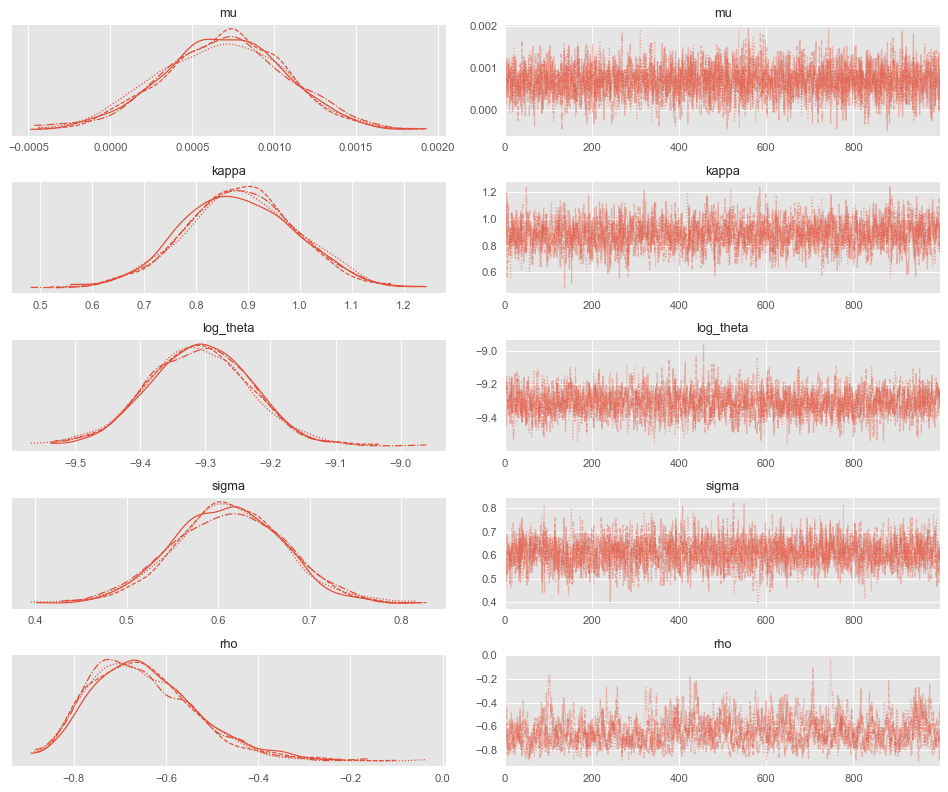

In [ ]:
az.plot_trace(idata, var_names=['mu', 'kappa', 'log_theta', 'sigma', 'rho'])
plt.tight_layout()
plt.show()

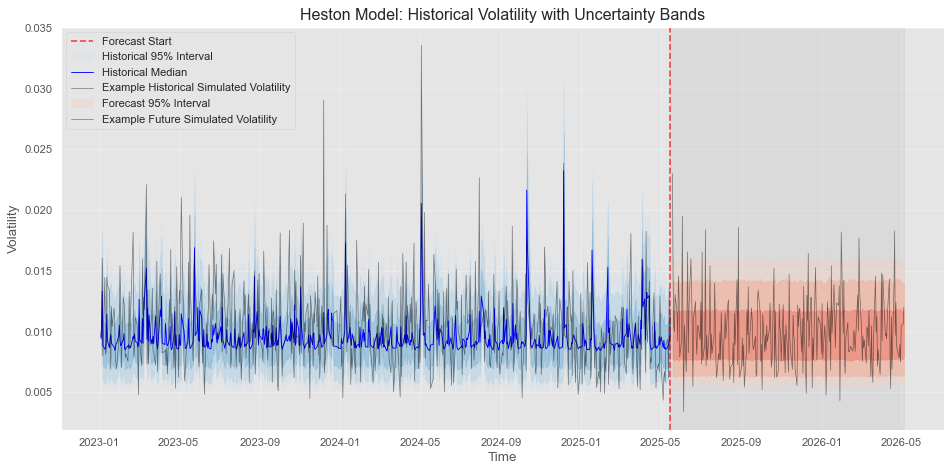

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

# Extract posterior volatility estimate (mean across chains)
sigma_est = idata.posterior['sigma_t'].mean(dim=["chain", "draw"]).values

# Get historical volatility samples and calculate quantiles
historical_vol_samples = idata.posterior['sigma_t'].stack(sample=("chain", "draw")).values
historical_vol_quantiles = np.quantile(historical_vol_samples, quantiles, axis=1)

# Extract future volatility paths from posterior predictive
future_vol_samples = np.sqrt(idata.posterior_predictive['v_future'].stack(sample=("chain", "draw")).values)

# Calculate quantiles for future volatility
quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
future_vol_quantiles = np.quantile(future_vol_samples, quantiles, axis=1)

# Create timeline for complete plot
full_timeline = coords['T'] + coords['T_future']

# Create plot
plt.figure(figsize=(12, 6))

# Add separation line and shaded region
plt.axvline(x=coords['T'][-1], color='red', linestyle='--', alpha=0.7, label='Forecast Start')
plt.axvspan(coords['T'][-1], full_timeline[-1], alpha=0.1, color='gray')

# Create gradient fill between quantiles using a loop
cmap = plt.get_cmap('Blues')
interval_labels = ['95%', '80%', '50%']

# For historical volatility
for i in range(3):
    lower_idx = i
    upper_idx = -(i+1)
    color_val = 0.2 + 0.2*i  # Progressively darker blue
    
    plt.fill_between(
        coords['T'], 
        historical_vol_quantiles[lower_idx], 
        historical_vol_quantiles[upper_idx],
        color=cmap(color_val), 
        alpha=0.3, 
        label=f'Historical {interval_labels[i]} Interval' if i == 0 else ""
    )

# Plot historical median
plt.plot(
    coords['T'], 
    historical_vol_quantiles[3], 
    color='blue', 
    lw=0.8, 
    label='Historical Median'
)

# plot random sample of historical volatility paths
for i in range(1):
    plt.plot(
        coords['T'], 
        historical_vol_samples[:,i], 
        color='black', 
        alpha=0.5, 
        linewidth=0.6,
        label ='Example Historical Simulated Volatility' if i == 0 else ""
    )

cmap = plt.get_cmap('Reds')
for i in range(3):
    lower_idx = i
    upper_idx = -(i+1)
    color_val = 0.2 + 0.2*i  # Progressively darker red
    
    plt.fill_between(
        coords['T_future'], 
        future_vol_quantiles[lower_idx], 
        future_vol_quantiles[upper_idx],
        color=cmap(color_val), 
        alpha=0.3, 
        label=f'Forecast {interval_labels[i]} Interval' if i == 0 else ""
    )



# plot 20 simulated future volatility paths
for i in range(1):
    plt.plot(
        coords['T_future'], 
        future_vol_samples[:,i], 
        color='black', 
        alpha=0.5, 
        linewidth=0.6,
        label ='Example Future Simulated Volatility' if i == 0 else ""
    )


plt.title('Heston Model: Historical Volatility with Uncertainty Bands')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


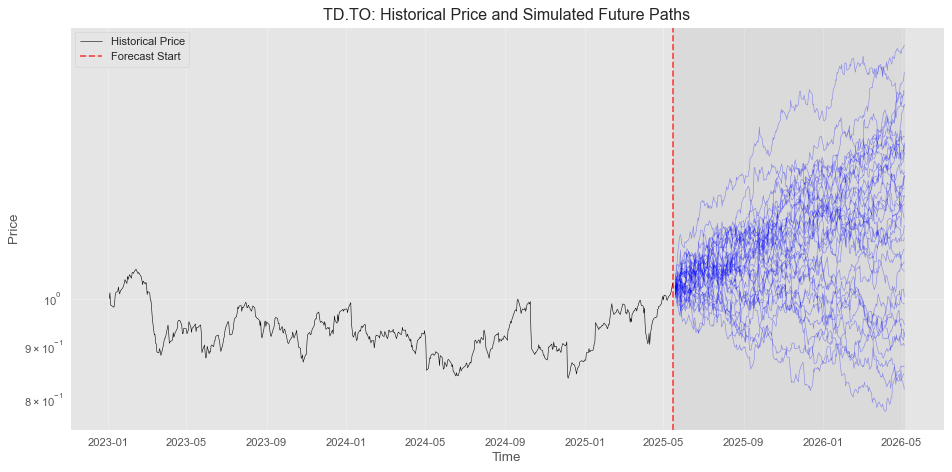

In [ ]:
# Extract the future returns from posterior predictive
future_returns = idata.posterior_predictive['returns_future'].stack(sample=("chain", "draw")).values

# Get the last actual price from the data
last_price = np.exp(df.log_ret.values).cumprod()[-1]

# Create future price paths (starting from last observed price)
future_prices = last_price * np.exp(np.cumsum(future_returns, axis=0))

# Plot historical price and simulated future paths
plt.figure(figsize=(12, 6))

# Plot the historical price path
historical_price = np.exp(df.log_ret.values).cumprod()
plt.plot(coords['T'], historical_price, color='black', lw=0.5, label='Historical Price')

# Plot future price paths
for i in range(35):
    plt.plot(coords['T_future'], future_prices[:, i], alpha=0.4, lw =0.5, color='blue')

# Add vertical line to separate historical and future periods
plt.axvline(x=coords['T'][-1], color='red', linestyle='--', alpha=0.7, label='Forecast Start')

# Add shaded region for forecast
plt.axvspan(coords['T'][-1], coords['T_future'][-1], alpha=0.1, color='gray')

plt.title(f"{stock_name}: Historical Price and Simulated Future Paths")
plt.xlabel("Time")
plt.ylabel("Price")
# setting y scale log
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()